# ADA CAPI Notebook for Data Exploration

In [82]:
import pandas as pd
import networkx as nx
import numpy as np
import os
import urllib
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy import stats 

# Imports to perform article analysis
import textstat
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

nltk.download('punkt') # Punkt tokenizer
nltk.download('stopwords') # Commong stopwords

# load config and extract variables
import config
DATA_PATH = config.PATH_TO_DATA
PATH_GRAPGH_FOLDER = "wikispeedia_paths-and-graph"
ARTICLE_FOLDER = "plaintext_articles"
GENERATED_METRICS = "generated_data"

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juangarcia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juangarcia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading and Preparing the Data
Load and clean up the paths, load into weighted graph structure etc.

#### Load Tabular Data

In [55]:
# load in all data (except wikipedia articles)
finished_paths = pd.read_csv(os.path.join(DATA_PATH, PATH_GRAPGH_FOLDER, "paths_finished.tsv"), sep='\t', skiprows=15, names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"])
unfinished_paths = pd.read_csv(os.path.join(DATA_PATH, PATH_GRAPGH_FOLDER, "paths_unfinished.tsv"), sep='\t', skiprows=16, names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"])
edges = pd.read_csv(os.path.join(DATA_PATH, PATH_GRAPGH_FOLDER, "links.tsv"), sep='\t', skiprows=15, names=["start", "end"], encoding="utf-8")
articles = pd.read_csv(os.path.join(DATA_PATH, PATH_GRAPGH_FOLDER, "articles.tsv"), sep='\t', skiprows=12, names=["article"], encoding="utf-8")
categories = pd.read_csv(os.path.join(DATA_PATH, PATH_GRAPGH_FOLDER, "categories.tsv"), sep='\t', skiprows=13, names=["article", "category"], encoding="utf-8")
shortest_paths = np.genfromtxt(os.path.join(DATA_PATH, PATH_GRAPGH_FOLDER, "shortest-path-distance-matrix.txt"), delimiter=1, dtype=np.uint8)

In [56]:
display(finished_paths.info())
display(finished_paths.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51318 entries, 0 to 51317
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   hashedIpAddress  51315 non-null  object 
 1   timestamp        51318 non-null  int64  
 2   durationInSec    51318 non-null  int64  
 3   path             51318 non-null  object 
 4   rating           28501 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.0+ MB


None

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [57]:
display(unfinished_paths.info())
display(unfinished_paths.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24875 entries, 0 to 24874
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   hashedIpAddress  24875 non-null  object
 1   timestamp        24875 non-null  int64 
 2   durationInSec    24875 non-null  int64 
 3   path             24875 non-null  object
 4   target           24875 non-null  object
 5   type             24875 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


None

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [58]:
display(edges.info())
display(edges.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119879 entries, 0 to 119878
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   start   119879 non-null  object
 1   end     119879 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


None

,start,end
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Monarchy
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Orkney


In [59]:
display(articles.info())
display(articles.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4604 entries, 0 to 4603
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  4604 non-null   object
dtypes: object(1)
memory usage: 36.1+ KB


None

,article
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


In [60]:
display(categories.head())
display(categories.head())

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [61]:
# shortest paths corresponds to numpy matrix, where 255 signifies no path (underscore in the .txt file), the diagonal is zero
# the row index is the zero-based index corresponding to the index in the articles dataframe, same for the columns (target article)
print((np.diag(shortest_paths)==0).all())
shortest_paths

True


array([[  0, 255, 255, ...,   4,   4,   2],
       [255,   0, 255, ...,   3,   3,   3],
       [255, 255,   0, ...,   3,   3,   3],
       ...,
       [255, 255, 255, ...,   0,   3,   3],
       [255, 255, 255, ...,   4,   0,   3],
       [255, 255, 255, ...,   3,   3,   0]], dtype=uint8)

#### Clean Tabular Data

In [62]:
# Clean up edge list
display(edges.head())
edges["start"] = edges.start.apply(urllib.parse.unquote)
edges["end"] = edges.end.apply(urllib.parse.unquote)
display(edges.head())

,start,end
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Monarchy
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Orkney


,start,end
0,Áedán_mac_Gabráin,Great_Britain
1,Áedán_mac_Gabráin,Ireland
2,Áedán_mac_Gabráin,Isle_of_Man
3,Áedán_mac_Gabráin,Monarchy
4,Áedán_mac_Gabráin,Orkney


In [63]:
# format datetime as datetime object
finished_paths["datetime"] = finished_paths.timestamp.apply(datetime.datetime.fromtimestamp)
unfinished_paths["datetime"] = unfinished_paths.timestamp.apply(datetime.datetime.fromtimestamp)
display(unfinished_paths.head())

,hashedIpAddress,timestamp,durationInSec,path,target,type,datetime
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,2011-02-07 06:02:15
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,2011-02-07 06:14:11
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,2011-02-07 16:00:19
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,2011-02-07 17:06:01
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,2011-02-07 18:18:25


In [64]:
# clean up url encoding for articles
display(articles.head())
articles["article"] = articles.article.apply(urllib.parse.unquote)
display(articles.head())

,article
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


,article
0,Áedán_mac_Gabráin
1,Åland
2,Édouard_Manet
3,Éire
4,Óengus_I_of_the_Picts


In [65]:
# clean up url encoding for categories
display(categories.head())
categories["article"] = categories.article.apply(urllib.parse.unquote)
display(categories.head())

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists


In [66]:
# merge articles and categories
articles_categories = pd.merge(articles, categories, how="left", on="article")
display(articles_categories.head())
# 6 articles without category!
print("Merge introduced {} NAs in category columns:".format(articles_categories.category.isna().sum()))
articles_categories[articles_categories.category.isna()]

,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists


Merge introduced 6 NAs in category columns:


,article,category
1360,Directdebit,NaN
1385,Donation,NaN
1811,Friend_Directdebit,NaN
3670,Pikachu,NaN
4342,Sponsorship_Directdebit,NaN
5141,Wowpurchase,NaN


In [69]:
# Convert paths to a readable format (lists)

finished_paths["path"] = finished_paths["path"].apply(lambda x: x.split(";"))
finished_paths["path"] = finished_paths["path"].apply(lambda x: [urllib.parse.unquote(y) for y in x])

unfinished_paths["path"] = unfinished_paths["path"].apply(lambda x: x.split(";"))
unfinished_paths["path"] = unfinished_paths["path"].apply(lambda x: [urllib.parse.unquote(y) for y in x])
unfinished_paths["target"] = unfinished_paths["target"].apply(urllib.parse.unquote)

AttributeError: 'list' object has no attribute 'split'

In [71]:
# functions to get all links between articles
from itertools import tee
def pairwise(iterable):
    # from python docs - will be introduced in version 3.10
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


def get_all_links(df, path_colname="path"):
    edge_counter = {}
    for _, row in df.iterrows():
        
        links = row['path']
        edges = list(pairwise(links))

        for edge in edges:
            if edge in edge_counter:
                edge_counter[edge] += 1
            else:
                edge_counter[edge] = 1

    out = pd.Series(edge_counter).reset_index()
    out.columns = ["source", "target", "weight"]
    return out

In [72]:
# get all finished links
finished_links = get_all_links(finished_paths)
finished_links.sort_values(by="weight", ascending=False) # TODO: what is up with these <<< signs?

,source,target,weight
66,<,<,4971
8550,Communication,Telephone,533
25,North_America,United_States,492
579,Animal,Mammal,487
2127,Lion,Zebra,472
...,...,...,...
34539,Latin_America,Guyana,1
34538,Wine,Latin_America,1
34532,Crow,Dove,1
34530,Symmetry,Physics,1


In [73]:
# get all unfinished links
unfinished_links = get_all_links(unfinished_paths)
unfinished_links.sort_values(by="weight", ascending=False) # TODO: what is up with these <<< signs?

,source,target,weight
63,<,<,3814
5155,Pyramid,Mexico,278
5209,Brain,Computer_science,222
392,Animal,Mammal,187
159,<,United_States,171
...,...,...,...
18326,Electromagnetic_radiation,Gauss's_law,1
18324,History_of_computing_hardware,History_of_the_Internet,1
18323,Scurvy,Pellagra,1
18322,River,Germany,1


count    2788.000000
mean        1.495696
std        13.778984
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       240.000000
dtype: float64

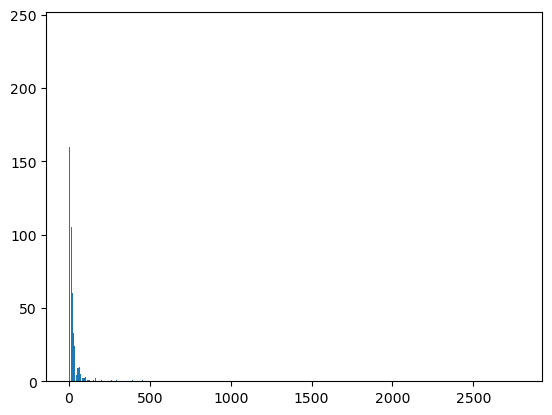

In [74]:
# create newtorkx graph from finished paths
finished_graph = nx.from_pandas_edgelist(finished_links,source="source", target="target", edge_attr="weight")
hist = nx.degree_histogram(finished_graph)
plt.bar(range(len(hist)), hist)
pd.Series(hist).describe()

count    2284.000000
mean        1.761821
std        18.526944
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       363.000000
dtype: float64

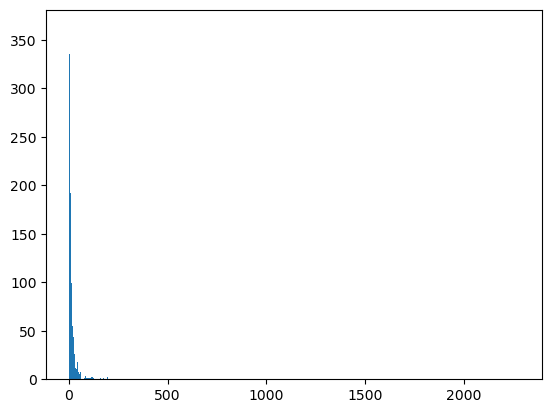

In [75]:
# create newtorkx graph from unfinished paths
unfinished_graph = nx.from_pandas_edgelist(unfinished_links,source="source", target="target", edge_attr="weight")
hist = nx.degree_histogram(unfinished_graph)
plt.bar(range(len(hist)), hist)
pd.Series(hist).describe()

#### Load Article data

##### Metrics to be extracted from articles

* Total word count: To understand the length of the article.
* Non stopword frequency: To identify words that contribute to the content's meaning.
* Stopword frequency: To identify common words that may not contribute to the content's meaning.
* Average word length: To assess the complexity of the language used.
* Average sentence length: Longer or more complex sentences (based on characters) may contribute to frustration.
* Number of paragraphs: To see if the article's structure plays a role in people giving up.
* Keyword frequency: To identify the most common keywords to understand the article's focus.
* Readability: Ease of reading the article (metric: Flesch Reading Ease Score) Link: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests

In [79]:
def proprocess_article(article_text):
    preprocessed_text = article_text
    preprocessed_text = preprocessed_text.lower()
    preprocessed_text = preprocessed_text.replace("\n   ", " ") # As the articles are not continuous sentences
    return preprocessed_text

def calculate_article_metrics(article_text):
    preprocessed_text = proprocess_article(article_text)

    words = word_tokenize(preprocessed_text)
    sentences = sent_tokenize(preprocessed_text)

    # Calculate total word count
    total_word_count = len(words)

    # Calculate stopword frequency
    stop_words = set(stopwords.words("english"))
    stopwords_count = 0
    unique_words = []
    for word in words:
        if word.isalpha() and word.lower() in stop_words:
            stopwords_count +=1
        if word.isalpha() and word.lower() not in stop_words:
            unique_words.append(word.lower())

    # Calculate average word length
    average_word_length = sum(len(word) for word in words) / total_word_count

    # Calculate average sentence length
    average_sentence_length = sum(len(sentence) for sentence in sentences) / len(sentences)

    # Calculate number of paragraphs (assume every new line \n is paragraph)
    paragraphs_count = preprocessed_text.count('\n') + 1 # Count last paragraph

    # Calculate keyword frequency
    word_freq = nltk.FreqDist(unique_words)
    most_common_words = word_freq.most_common(10)  # Parameter to adjust

    # Calculate readability (Flesch Reading Ease Score) - 100: Easy to read, 0: Very confusing
    readability = textstat.flesch_reading_ease(preprocessed_text)

    return {
        "word_count": total_word_count,
        "non_stopword_count": total_word_count - stopwords_count,
        "stopword_count": stopwords_count,
        "avg_word_length": average_word_length,
        "avg_sent_length": average_sentence_length,
        "paragraph_count": paragraphs_count,
        "common_words": most_common_words,
        "readability_score": readability,
    }

##### Loading the article data
To reduce runtime, we compute the article metrics once and then read the generated csv file.

In [84]:
"""
folder_path = os.path.join(DATA_PATH, ARTICLE_FOLDER)
if os.path.exists(folder_path) and os.path.isdir(folder_path):

  article_metrics = pd.DataFrame(columns=["article", "word_count", "non_stopword_count", "stopword_count", "avg_word_length", "avg_sent_length", "paragraph_count", "common_words", "readability_score"])

  for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    
    if os.path.isfile(file_path):
      root, extension = os.path.splitext(file_name)
      readable_file_name = urllib.parse.unquote(root)
      
      with open(file_path, "r", encoding="utf-8") as article:
        metrics = calculate_article_metrics(article.read())

        metrics["article"] = readable_file_name
        article_metrics.loc[len(article_metrics)] = metrics
else:
  raise FileNotFoundError("The specified folder path does not exist or is not a directory.")

article_metrics.to_csv(os.path.join(GENERATED_METRICS, "article_metrics.csv"), index=False)
"""

'\nfolder_path = os.path.join(DATA_PATH, ARTICLE_FOLDER)\nif os.path.exists(folder_path) and os.path.isdir(folder_path):\n\n  article_metrics = pd.DataFrame(columns=["article", "word_count", "non_stopword_count", "stopword_count", "avg_word_length", "avg_sent_length", "paragraph_count", "common_words", "readability_score"])\n\n  for file_name in os.listdir(folder_path):\n    file_path = os.path.join(folder_path, file_name)\n    \n    if os.path.isfile(file_path):\n      root, extension = os.path.splitext(file_name)\n      readable_file_name = urllib.parse.unquote(root)\n      \n      with open(file_path, "r", encoding="utf-8") as article:\n        metrics = calculate_article_metrics(article.read())\n\n        metrics["article"] = readable_file_name\n        article_metrics.loc[len(article_metrics)] = metrics\nelse:\n  raise FileNotFoundError("The specified folder path does not exist or is not a directory.")\n\narticle_metrics.to_csv(os.path.join(GENERATED_METRICS, "article_metrics.csv"

In [85]:
article_metrics = pd.read_csv(os.path.join(GENERATED_METRICS, "article_metrics.csv"))

In [87]:
display(article_metrics.info())
display(article_metrics.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4604 entries, 0 to 4603
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   article             4604 non-null   object 
 1   word_count          4604 non-null   int64  
 2   non_stopword_count  4604 non-null   int64  
 3   stopword_count      4604 non-null   int64  
 4   avg_word_length     4604 non-null   float64
 5   avg_sent_length     4604 non-null   float64
 6   paragraph_count     4604 non-null   int64  
 7   common_words        4604 non-null   object 
 8   readability_score   4604 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 323.8+ KB


None

,article,word_count,non_stopword_count,stopword_count,avg_word_length,avg_sent_length,paragraph_count,common_words,readability_score
0,Second_Crusade,4901,2965,1936,4.348908,166.686275,59,"[('crusade', 45), ('louis', 39), ('conrad', 31...",63.83
1,Navassa_Island,1931,1365,566,4.614190,155.014493,32,"[('island', 56), ('navassa', 31), ('guano', 10...",54.73
2,Evan_Rachel_Wood,1213,815,398,4.469085,178.416667,32,"[('wood', 31), ('role', 10), ('roles', 7), ('f...",52.33
3,Tropical_Storm_Henri_(2003),1846,1347,499,4.584507,135.013514,39,"[('henri', 28), ('storm', 23), ('tropical', 21...",55.24
4,Final_Fantasy_Adventure,1371,899,472,4.429613,143.843137,33,"[('game', 25), ('final', 18), ('fantasy', 18),...",58.82


### General Data Exploration
Explore distribution of all relevant variables, analyze and potentially fill missing values, sîmple summary stats

#### Explore Path lengths across finished and unfinished paths

In [ ]:
# distribution of path lengths disaggregated across finished and unfinished
unfinished_paths["path_length"] = unfinished_paths.path.apply(lambda el: len(el.split(";")))
finished_paths["path_length"] = finished_paths.path.apply(lambda el: len(el.split(";")))

print("Finished Paths: Length")
display(finished_paths["path_length"].describe())
display(finished_paths.path_length.value_counts())

print("Unfinished Paths: Length")
display(unfinished_paths["path_length"].describe())
unfinished_paths.path_length.value_counts()


In [ ]:
# make plot of path lengths
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), sharey=True)

sns.histplot(data=finished_paths, x="path_length", ax=axes[0])
axes[0].set_title("Finished Paths")
sns.histplot(data=unfinished_paths, x="path_length", ax=axes[1], hue="type")
axes[1].set_title("Uninished Paths")

# --> highly skewed and many unlikely outcomes (e.g. unfinished paths path length = 1, did they really give up? or not play at all?)

In [ ]:

# make plot of path lengths
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey=True)
threshold = 30


sns.histplot(x=finished_paths.path_length[finished_paths.path_length < threshold], ax=axes[0], discrete=True)
axes[0].set_title("Finished Paths")

unfinished_clean = unfinished_paths[(unfinished_paths.path_length < threshold) & (unfinished_paths.type == "restart")]
sns.histplot(data=unfinished_clean, x="path_length", ax=axes[1], discrete=True,)
axes[1].set_title("Uninished Paths - Restart")

unfinished_clean = unfinished_paths[(unfinished_paths.path_length < threshold) & (unfinished_paths.type == "timeout")]
sns.histplot(data=unfinished_clean, x="path_length", ax=axes[2], discrete=True,)
axes[2].set_title("Uninished Paths - Timeout")

#### Explore categories in the paths

In [ ]:
# Seeing which categories are most represented in articles

categories["broad_category"] = categories["category"].apply(lambda x: x.split(".")[1])

count_articles = categories.groupby("broad_category").size()

print("Below shows how many articles each of the broad categories are represented by")
display(count_articles)

In [ ]:
# Create dictionaries for easy discovery of what categories an article belongs to

article_to_category = {}
article_to_broad_category = {}
for i in range(len(categories)):
    if categories.iloc[i]["article"] in article_to_category:
        article_to_category[categories.iloc[i]["article"]].append(categories.iloc[i]["category"])
        article_to_broad_category[categories.iloc[i]["article"]].append(categories.iloc[i]["broad_category"])
    else:
        article_to_category[categories.iloc[i]["article"]] = [categories.iloc[i]["category"]]
        article_to_broad_category[categories.iloc[i]["article"]] = [categories.iloc[i]["broad_category"]]

In [ ]:
# Count how many times each category has occured as a target in the finished and unfinished paths
# NOTE THAT SOME ARTICLES ARE REPRESENTED BY MULTIPLE CATEGORIES AND ARE COUNTED TWICE

all_target_broad_categories_f = [article_to_broad_category[target] for target in [path[-1] for path in finished_paths["path"]] \
                                 if target in article_to_broad_category]
all_target_broad_categories_f = [item for sublist in all_target_broad_categories_f for item in sublist]
count_cats_finished_target = Counter(all_target_broad_categories_f)
keys = list(count_cats_finished_target.keys())
keys.sort()
sorted_cats_f = {i: count_cats_finished_target[i] for i in keys}
#display(sorted_cats_f)

all_target_broad_categories_u = [article_to_broad_category[target] for target in unfinished_paths["target"] \
                                 if target in article_to_broad_category]
all_target_broad_categories_u = [item for sublist in all_target_broad_categories_u for item in sublist]
count_cats_unfinished_target = Counter(all_target_broad_categories_u)
keys = list(count_cats_unfinished_target.keys())
keys.sort()
sorted_cats_u = {i: count_cats_unfinished_target[i] for i in keys}
#display(sorted_cats_u)

ax = plt.barh(list(sorted_cats_f.keys()), sorted_cats_f.values(), label="Finished paths")
ax2 = plt.barh(list(sorted_cats_u.keys()), sorted_cats_u.values(), label="Unfinished paths")
plt.xlabel("Count")
plt.title("Occurences of categories as targets")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [ ]:
# Which countries are targets in finished paths

country_targets_f = [target for target in [path[-1] for path in finished_paths["path"]] \
                     if target in article_to_broad_category and "Countries" in article_to_broad_category[target]]
count_countries_finished_target = Counter(country_targets_f)
display(count_countries_finished_target)

In [ ]:
# Which countries are targets in unfinished paths

country_targets_u = [target for target in unfinished_paths["target"] \
                     if target in article_to_broad_category and "Countries" in article_to_broad_category[target]]
count_countries_unfinished_target = Counter(country_targets_u)
display(count_countries_unfinished_target)

# There are certainly some trends here. Haiti, Samoa, and the Gaza Strip, for example, are over-represented in the unfinished paths
# when compared to the finished paths.


In [ ]:
# In fact we can see that there are some countries that occured as a target more in unfinished paths than in finished paths
count_countries_unfinished_target - count_countries_finished_target

In [ ]:
total_country_counts = count_countries_unfinished_target + count_countries_finished_target
country_percent_in_unfinished = total_country_counts.copy()
country_percent_in_finished = total_country_counts.copy()

for item, count in country_percent_in_unfinished.items():
    country_percent_in_unfinished[item] = count_countries_unfinished_target[item] / total_country_counts[item]

for item, count in country_percent_in_finished.items():
    country_percent_in_finished[item] = count_countries_finished_target[item] / total_country_counts[item]

In [ ]:
country_percent_in_unfinished

In [ ]:
country_percent_in_finished

#### Exploring subject strength between connected article

In [ ]:
edge_article_df = edges.copy()

def add_categories(row, column):
    article_name = row[column]
    if article_name in article_to_broad_category:
        return article_to_broad_category[article_name]
    else:
        return []

edge_article_df['start_categories'] = edge_article_df.apply(add_categories, args=("start",), axis=1)
edge_article_df['end_categories'] = edge_article_df.apply(add_categories, args=("end",), axis=1)
display(edge_article_df)

In [ ]:
# Visualizing article connections per category
graph = nx.DiGraph()

for index, row in edge_article_df.iterrows():
    start_article = row['start'][0]
    for start_category in row['start_categories']:
      graph.add_node(start_category)
      for end_category in row['end_categories']:
        graph.add_node(end_category)

        if graph.has_edge(start_category, end_category):
          graph[start_category][end_category]['weight'] += 1
        else:
          graph.add_edge(start_category, end_category, weight=1)

edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]
max_edge_weight = max(edge_weights)
min_edge_weight = min(edge_weights)
normalized_edge_weights = [(weight - min_edge_weight) / (max_edge_weight - min_edge_weight) for weight in edge_weights]
edge_widths = [weight * 4 for weight in normalized_edge_weights]

figure = nx.shell_layout(graph)
plt.figure(figsize=(8, 8))
nx.draw(graph, figure, with_labels=True, width=edge_widths, edge_color='gray', arrows=True)
plt.title("Article Connections Based on Category (Normalized and Scaled Edges)")
plt.show()

In [ ]:
start = []
end = []
for path in finished_paths["path"]:
  start.append(path[0])
  end.append(path[-1])
  
finished_paths["start_article"] = start
finished_paths["end_article"] = end

finished_paths['start_categories'] = finished_paths.apply(add_categories, args=("start_article",), axis=1)
finished_paths['end_categories'] = finished_paths.apply(add_categories, args=("end_article",), axis=1)
#display(finished_paths)

In [ ]:
# Visualizing FINISHED PATHS article connections per category
graph = nx.DiGraph()
for index, row in finished_paths.iterrows():
    for start_category in row['start_categories']:
      graph.add_node(start_category)
      for end_category in row['end_categories']:
        graph.add_node(end_category)

        if graph.has_edge(start_category, end_category):
          graph[start_category][end_category]['weight'] += 1
        else:
          graph.add_edge(start_category, end_category, weight=1)

edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]
max_edge_weight = max(edge_weights)
min_edge_weight = min(edge_weights)
normalized_edge_weights = [(weight - min_edge_weight) / (max_edge_weight - min_edge_weight) for weight in edge_weights]
edge_widths = [weight * 4 for weight in normalized_edge_weights]

figure = nx.shell_layout(graph)
plt.figure(figsize=(8, 8))
nx.draw(graph, figure, with_labels=True, width=edge_widths, edge_color='gray', arrows=True)
plt.title("Finished article Connections (Normalized and Scaled Edges)")
plt.show()

In [ ]:
start = []
end = []
for path in unfinished_paths["path"]:
  start.append(path[0])
  
unfinished_paths["start_article"] = start

unfinished_paths['start_categories'] = unfinished_paths.apply(add_categories, args=("start_article",), axis=1)
unfinished_paths['end_categories'] = unfinished_paths.apply(add_categories, args=("target",), axis=1)
#display(unfinished_paths)

In [ ]:
# Visualizing UNFINISHED PATHS article connections per category
graph = nx.DiGraph()
for index, row in unfinished_paths.iterrows():
    for start_category in row['start_categories']:
      graph.add_node(start_category)
      for end_category in row['end_categories']:
        graph.add_node(end_category)

        if graph.has_edge(start_category, end_category):
          graph[start_category][end_category]['weight'] += 1
        else:
          graph.add_edge(start_category, end_category, weight=1)

edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]
max_edge_weight = max(edge_weights)
min_edge_weight = min(edge_weights)
normalized_edge_weights = [(weight - min_edge_weight) / (max_edge_weight - min_edge_weight) for weight in edge_weights]
edge_widths = [weight * 4 for weight in normalized_edge_weights]

figure = nx.shell_layout(graph)
plt.figure(figsize=(8, 8))
nx.draw(graph, figure, with_labels=True, width=edge_widths, edge_color='gray', arrows=True)
plt.title("Unfinished article Connections (Normalized and Scaled Edges)")
plt.show()

#### Analyzing articles metrics

In [ ]:
article_metrics["stopword_percentage"] = article_metrics["stopword_count"] / article_metrics["word_count"]
article_metrics["non_stopword_percentage"] = article_metrics["non_stopword_count"] / article_metrics["word_count"]

In [ ]:
display(article_metrics.head())

In [ ]:
# Show the article metrics per subject
article_metrics_with_subjects = article_metrics.merge(categories, how="left", on=["article"])

In [ ]:
things_to_plot = ['word_count', 'stopword_count', 'stopword_percentage', 'non_stopword_count', 'non_stopword_percentage','avg_word_length', 'avg_sent_length', 'paragraph_count','readability_score']
fig, axes = plt.subplots(nrows=len(things_to_plot), ncols=1, figsize=(10, 6 * len(things_to_plot)))

for idx, metric in enumerate(things_to_plot):
  ax = axes[idx]
  sns.barplot(x=article_metrics_with_subjects["broad_category"], y=article_metrics_with_subjects[metric], errorbar=("ci", 95), ax=ax)
  ax.set_xlabel("Category")
  ax.set_ylabel(metric)
  ax.set_title("Mean and CI of {} per Category".format(metric))
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
# Show the article metrics per finished and unfinished parths (both for start and end articles)
start_finished_article_metrics = finished_paths.merge(article_metrics_with_subjects, how="left", left_on="start_article", right_on="article")
end_finished_article_metrics = finished_paths.merge(article_metrics_with_subjects, how="left", left_on="end_article", right_on="article")
start_unfinished_article_metrics = unfinished_paths.merge(article_metrics_with_subjects, how="left", left_on="start_article", right_on="article")
end_unfinished_article_metrics = unfinished_paths.merge(article_metrics_with_subjects, how="left", left_on="target", right_on="article")

In [ ]:
things_to_plot = ['word_count', 'stopword_count', 'stopword_percentage', 'non_stopword_count', 'non_stopword_percentage','avg_word_length', 'avg_sent_length', 'paragraph_count','readability_score']
dataframes = [start_finished_article_metrics, start_unfinished_article_metrics, end_finished_article_metrics, end_unfinished_article_metrics]
dataframe_labels = ['Start Finished', 'Start Unfinished', 'End Finished', 'End Unfinished']


fig, axes = plt.subplots(nrows=len(things_to_plot), ncols=1, figsize=(10, 6 * len(things_to_plot)))

for idx, metric in enumerate(things_to_plot):
  ax = axes[idx]
  data = [df[metric] for df in dataframes]
  sns.barplot(data=data, errorbar=("ci", 95), ax=ax)
  ax.set_xlabel("Category")
  ax.set_ylabel(metric)
  ax.set_title("Mean and CI of {} per Category".format(metric))
  ax.set_xticklabels(dataframe_labels)

plt.tight_layout()
plt.show()

In [ ]:
print("Start Articles (comparing finished vs unfinished)")
for metric in things_to_plot:
  statistic, pvalue = stats.ttest_ind(start_finished_article_metrics[metric], start_unfinished_article_metrics[metric], nan_policy="omit")
  print("{} - statistic: {}, p-value: {}".format(metric, statistic, pvalue))

print("\nTarget Articles (comparing finished vs unfinished)")
for metric in things_to_plot:
  statistic, pvalue = stats.ttest_ind(end_finished_article_metrics[metric], end_unfinished_article_metrics[metric], nan_policy="omit")
  print("{} - statistic: {}, p-value: {}".format(metric, statistic, pvalue))

TODO: percentage wise, from start to end, what categories are used

### Analyze links to targets in finished vs unfinished articles

In [ ]:
finished_paths["links_to_target"] = finished_paths["path"].apply(lambda x: len(edges.loc[edges["end"] == x[-1]]))
unfinished_paths["links_to_target"] = unfinished_paths["target"].apply(lambda x: len(edges.loc[edges["end"] == x]))

In [ ]:
# Printing mean number of links to the targets in the finished and unfinished paths.
print(f"The targets that were reached had {finished_paths['links_to_target'].mean()} links on average pointing to them.")
print(f"The targets that were not reached had {unfinished_paths['links_to_target'].mean()} links on average pointing to them.")

In [ ]:
# Conducting a t-test
stats.ttest_ind(finished_paths["links_to_target"], unfinished_paths["links_to_target"])

In [ ]:
# Creating a boxplot of the trends

finished_links =  pd.DataFrame()
finished_links["links_to_target"] = finished_paths["links_to_target"]
finished_links["path_type"] = "Finished paths"

unfinished_links =  pd.DataFrame()
unfinished_links["links_to_target"] = unfinished_paths["links_to_target"]
unfinished_links["path_type"] = "Unfinished paths"

df_links = pd.concat([finished_links,unfinished_links])

ax = sns.boxplot(x="path_type", y="links_to_target", data=df_links)
plt.xlabel(" ")
plt.ylim([-5,155])
plt.ylabel("Number of links to target")

The p-value of a t-test between the number of links pointing to the targets of finished and unfinished paths is 0.0. This means we reject the null hypothesis that the number of links pointing to the targets are statistically the same at the 5% level of significance.

### Analyse possible shortest path distances

In [ ]:
# Retrieving the shortest possible paths for the finished games

finished_paths["shortest_path_length"] = finished_paths["path"].apply(
    lambda x: shortest_paths[articles.loc[articles['article'] == x[0]].index[0]][articles.loc[articles['article'] == x[-1]].index[0]]
    )


NOTE IMPORTANT: THERE ARE TYPOS


Eg. At index 141 in unfinished paths, the target is written as "Long_peper", when it should be "Long_pepper"

Overall, 28 times an issue arises in unfinished paths. Doesn't seem to be an issue in finished paths

In [ ]:
# Retrieving the shortest possible paths for the unfinished games

shortest_unfinished = []
not_found = 0
for i in range(len(unfinished_paths)):
    source = articles.loc[articles['article'] == unfinished_paths.iloc[i]["path"][0]]
    target = articles.loc[articles['article'] == unfinished_paths.iloc[i]["target"]]
    if len(source) != 0 and len(target) != 0:
        index_source = source.index[0]
        index_target = target.index[0]
        shortest_unfinished.append(int(shortest_paths[index_source][index_target]))
    else:
        shortest_unfinished.append(None)
        not_found+=1

unfinished_paths["shortest_path_length"] = shortest_unfinished
print(f"{not_found} shortest paths not found")

In [ ]:
# Testing to see if there are issues in the finished paths too

shortest_finished = []
not_found2 = 0
for i in range(len(finished_paths)):
    source = articles.loc[articles['article'] == finished_paths.iloc[i]["path"][0]]
    target = articles.loc[articles['article'] == finished_paths.iloc[i]["path"][-1]]
    if len(source) != 0 and len(target) != 0:
        index_source = source.index[0]
        index_target = target.index[0]
        shortest_finished.append(int(shortest_paths[index_source][index_target]))
    else:
        shortest_finished.append(None)
        not_found2+=1

print(f"{not_found2} shortest paths not found")

In [ ]:
# Counting number of "impossible" paths

print(f"There are {len(finished_paths[finished_paths['shortest_path_length'] == 255])} impossible finished paths.")
print(f"There are {len(unfinished_paths[unfinished_paths['shortest_path_length'] == 255])} impossible unfinished paths.")

In [ ]:
# Printing mean shortest possible paths in the finished and unfinished paths.
print(f"The shortest possible paths were {finished_paths['shortest_path_length'].mean()} long on average in the finished paths.")
print(f"The shortest possible paths were {unfinished_paths['shortest_path_length'].mean()} long on average in the unfinished paths.")

In [ ]:
# Doing a t test on the shortest path lengths
stats.ttest_ind(finished_paths['shortest_path_length'], unfinished_paths['shortest_path_length'], nan_policy="omit")

In [ ]:
# Creating a boxplot of the trends

finished_shortest =  pd.DataFrame()
finished_shortest["shortest_path_length"] = finished_paths[finished_paths['shortest_path_length'] != 255]["shortest_path_length"]
finished_shortest["path_type"] = "Finished paths"

unfinished_shortest =  pd.DataFrame()
unfinished_shortest["shortest_path_length"] = unfinished_paths[unfinished_paths['shortest_path_length'] != 255]["shortest_path_length"]
unfinished_shortest["path_type"] = "Unfinished paths"

df_shortest = pd.concat([finished_shortest,unfinished_shortest])

ax = sns.boxplot(x="path_type", y="shortest_path_length", data=df_shortest)
plt.xlabel(" ")
#plt.ylim([-5,155])
plt.ylabel("Shortest path possible from source to target")

The t test shows that indeed this is a significant difference. Unfinished paths are thus inherently more difficult to get to.

This is an interesting situation. The past two analyses show that the targets are more difficult to get to in the unfinished paths, due to the fewer links that point at them and the larger value of the possible shortest path to them.

A challenge for us may be to try to isolate whether the difference between whether a path is finished or not can be fully explained by more objective factors like this, or if there is a human component that we can isolate as well. Eg, are some categories actually more difficult to get to, or do the differences in the target category distributions in the finished and unfinished paths arise because some categories may be more likely to have longer possible shortest paths to them or have fewer links pointing at them?

We should explore these ideas

TODO: Start working on the questions above

### Analyze Networkx graph objects 
degreehistograms, etc. etc.

## Putting everything together
put all article clicks (before and after giving up, also include all succesfully finished paths) in a wide form df to run statistical anaylsis
- merge with article metrics
- merge with article categories
- merge with game information
- merge with player information
- merge with backclick information

In [ ]:
article_information = article_metrics.copy()
article_information["article_name"] = article_information["file_name"].apply(lambda name: name.split(".")[0])

# merge in categories
article_information = pd.merge(article_information, categories[["article", "broad_category"]], how="left", left_on="article_name", right_on="article")

keep = ['article_name',
        'word_count',
        'non_stopword_count',
        'stopword_count',
        'avg_word_length',
        'avg_sent_length',
        'paragraph_count',
        'readability_score',
        'broad_category']

article_information = article_information[keep]
article_information

## exploration per actual link 

In [ ]:
# create all links (with duplicates) and add a game ID (e.g., index of finsihed and unfinished path)

# add IDs
finished_paths["game_id"] = "F" + pd.Series(finished_paths.index).astype(str)
unfinished_paths["game_id"] = "U" + pd.Series(unfinished_paths.index).astype(str)

def get_all_clicks(df):
    out = []
    for index, row in df.iterrows():
        links = row['path'].split(';')
        
        edges = list(pairwise(links))
        game_id = row["game_id"]
        to_add = []
        clicks = 1
        for edge in edges:
            source, target = edge
            clicks += 1
            out.append([source, target, clicks, game_id])


    out = pd.DataFrame(out, columns=["source", "target", "num_step", "game_id"])
    return out



In [ ]:
# add 
finished_clicks = get_all_clicks(finished_paths)
finished_clicks["give_up"] = 0

In [ ]:
unfinished_paths_sample = unfinished_paths[unfinished_paths.path_length > 3]
unfinished_clicks = get_all_clicks(unfinished_paths_sample)
unfinished_clicks["give_up"] = 0
unfinished_clicks.loc[unfinished_clicks.groupby('game_id').tail(1).index, 'give_up'] = 1
unfinished_clicks

In [ ]:
all_clicks = pd.concat((finished_clicks.sample(10_000), unfinished_clicks), axis=0)
all_clicks = all_clicks.merge(article_information, how="left", left_on="source", right_on="article_name")
all_clicks

In [ ]:
data = all_clicks.dropna()
print(data.give_up.sum())
data.isna().any()

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod = smf.logit(formula='give_up ~ num_step + word_count + non_stopword_count + stopword_count + avg_word_length + avg_sent_length + paragraph_count + readability_score + C(broad_category)', data=data)
res = mod.fit(maxiter=100)
print(res.summary())

# not that interesting, the fiut is very very bad, it doesnt converge
# also, only statistically relevant thing is average sentence lenght.

## Exploration per Game

In [ ]:
# do same analysis on game level - can we predict whether they will give up before the game even started?

unfinished_paths["start"] = unfinished_paths.path.apply(lambda el: el.split(";")[0])
unfinished_paths["give_up"] = 1

# add start plus end category
finished_paths["start"] = finished_paths.path.apply(lambda el: el.split(";")[0])
finished_paths["target"] = finished_paths.path.apply(lambda el: el.split(";")[-1])
finished_paths["give_up"] = 0


keep = ["start", "target", "give_up", "shortest_path", "links_to_target"]
data = pd.concat((finished_paths[keep], unfinished_paths[keep]), axis=0)
data = data.merge(article_information[["article_name", "broad_category"]], how="left", left_on="start", right_on="article_name")
data = data.merge(article_information[["article_name", "broad_category"]], how="left", left_on="target", right_on="article_name")
data = data.drop(["article_name_x", "article_name_y"], axis=1)
data["not_same_cat"] = data["broad_category_x"] != data["broad_category_y"]
data

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod = smf.logit(formula='give_up ~ C(broad_category_y) + C(broad_category_x) + not_same_cat + shortest_path + links_to_target', data=data)
res = mod.fit(maxiter=100)
print(res.summary())

### Interesting takeawys: 
# some categories are statistically significnat (.e.g, countries, geography) and lower the probability
# some categories increase the proabaility
# having to switch categories from source to target increases the probability
# shortest path: the longer the shortest path, the higher the probability of giving up.

### We can easily further expand this analysis